## Tensorflow 2.0 tf.function using MNIST

### 1. Load MNIST dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, optimizers, Sequential, metrics

In [2]:
(xs, ys),_ = datasets.mnist.load_data()
print('datasets:', xs.shape, ys.shape, xs.min(), xs.max())

xs = tf.convert_to_tensor(xs, dtype=tf.float32) / 255.
db = tf.data.Dataset.from_tensor_slices((xs, ys))
db = db.batch(32).repeat(10)

datasets: (60000, 28, 28) (60000,) 0 255


### 2. Show the pictures

In [3]:
import matplotlib.pyplot as plt

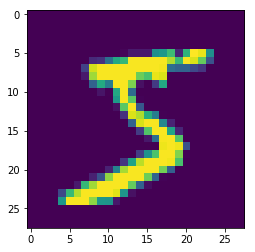

In [4]:
plt.imshow(xs[0])

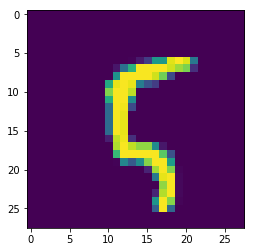

In [5]:
plt.imshow(xs[100])

### 3. Define function operator using tf.function

In [6]:
@tf.function
def add(a, b):
    return a + b

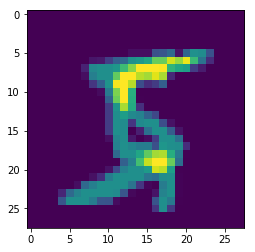

In [7]:
plt.imshow(add(xs[0],xs[100]))

It works!!!

### 4. Time check

###### We are going to make lstm model for time checking.

In [9]:
lstm_cell = tf.keras.layers.LSTMCell(10)
@tf.function
def fn(input, state):
    return lstm_cell(input, state)

input = tf.zeros([20, 10])
state = [tf.zeros([20, 10])] * 2

In [18]:
import timeit
lstm_cell(input, state)
fn(input, state)
print('Time of lstm_cell is {:04f}'.format(timeit.timeit(lambda: lstm_cell(input, state), number=10)))
print('Time of tf.function is {:04f}'.format(timeit.timeit(lambda: fn(input, state), number=10)))

Time of lstm_cell is 0.029063
Time of tf.function is 0.003409


### 5. Automatic control dependencies

In [32]:
a = tf.Variable(1.0)
b = tf.Variable(5.0)

In [33]:
@tf.function
def fn2(x, y):
    a.assign(y * b)
    b.assign_add(x * b)
    return a + b

In [34]:
fn2(1, 2).numpy()

20.0

In [35]:
fn2(10, 10).numpy()

210.0

In [40]:
v = tf.Variable(5.0)

@tf.function
def fn3(x):
    return v.assign_add(x)

In [41]:
fn3(10).numpy()  # 10 + 5.0

15.0

In [45]:
# Non-ambiguous code also works!
class C: pass
obj = C()
obj.v = None

@tf.function
def fn4(x):
    if obj.v is None:
        obj.v = tf.Variable(1.0)
    return obj.v.assign_add(v)

In [46]:
fn4(1.0).numpy()

16.0

In [47]:
fn4(2.0).numpy()

31.0

In [48]:
# Controlling autograph

@tf.function
def fn5(x):
    for i in tf.range(10):
        tf.print(i)  # will print every loop iteration
        tf.Assert(i < 10, ["a"])  # will check the dynamic value
        x += x
    return x

In [50]:
fn5(10).numpy()

0
1
2
3
4
5
6
7
8
9


10240

### 6. Apply tf.function to neural networks

In [52]:
# Define tf.function for conditional layers

@tf.function
def add_layer(x):
    if str(x.layers[-1].activation)[10:15] == 'relu':
        x.add(layers.Dense(10, activation='linear'))
    else:
        x.add(layers.Dense(10, activation='sigmoid'))

In [53]:
# Build neural network using keras Sequential API

network = Sequential([layers.Dense(256, activation='relu'),
                     layers.Dense(256, activation='relu'),
                     layers.Dense(256, activation='relu')])

In [54]:
# Apply `add_layer`
add_layer(network)

In [56]:
# Make sure you actually added a new layer
network.build(input_shape=(None, 28*28))
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  200960    
_________________________________________________________________
dense_1 (Dense)              multiple                  65792     
_________________________________________________________________
dense_2 (Dense)              multiple                  65792     
_________________________________________________________________
dense (Dense)                multiple                  2570      
Total params: 335,114
Trainable params: 335,114
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# If you want, then you can train this model like below :)
optimizer = optimizers.SGD(lr=0.01)
acc_meter = metrics.Accuracy()

for step, (x, y) in enumerate(db):
    
    with tf.GradientTape() as tape:
        x = tf.reshape(x, (-1, 28*28))
        out = network(x)
        
        y_onehot = tf.one_hot(y, depth=10)
        
        loss = tf.square(out - y_onehot)
        loss = tf.reduce_sum(loss) / 32
        
    acc_meter.update_state(tf.argmax(out, axis=1), y)
    
    grads = tape.gradient(loss, network.trainable_variables)
    optimizer.apply_gradients(zip(grads, network.trainable_variables))